Here you will learn to submit your model to a machine learning competition in Python.  It's fun, and it will give you a way to see your progress as your skills keep improving.*

# Introduction
Machine learning competitions are a great way to improve your skills and measure your progress as a data scientist. If you are using data from a competition on Kaggle, you can easily submit it from your notebook.  Here's how you do it.

# Example
We're doing very minimal data set up here so we can focus on how to submit modeling results to competitions. Other tutorials will teach you how build great models. So the model in this example will be fairly simple. We'll start with the code to read data, select predictors, and fit a model.

In [1]:
import pip
import sys
#if not 'sklearn' in sys.modules.keys():
#    pip.main(['install', 'sklearn'])
#if not 'kaggle' in sys.modules.keys():
#    pip.main(['install', 'kaggle'])
import random

print("Random number with seed 2020")
# first call
random.seed(2020)


Random number with seed 2020


In [2]:
import numpy as np
import pandas as pd
import graphviz

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Read the data
train = pd.read_csv('https://raw.githubusercontent.com/serivan/mldmlab/master/Datasets/Kaggle2020/train.csv')


## Feature engineering phase

In [3]:
# pull data into target (y) and predictors (X)
train_y = train.Quality
predictor_cols = ['fixed.acidity','volatile.acidity','citric.acid','residual.sugar','chlorides','free.sulfur.dioxide','total.sulfur.dioxide','density','pH','sulphates','alcohol']

# Create training predictors data
train_X = train[predictor_cols]

# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(train_X)


# Impute our data, then train
train_X_imp = imp.transform(train_X)


## Training

### You can train directly on the training set

In [4]:
my_model = DecisionTreeClassifier(random_state=1)
my_model.fit(train_X_imp, train_y)
my_model.score(train_X_imp, train_y)

1.0

In [5]:
# The snippet below will retrieve the feature importances from the model and make them into a DataFrame.
feature_importances = pd.DataFrame(my_model.feature_importances_,
                                   index = train_X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
alcohol,0.200932
volatile.acidity,0.121432
free.sulfur.dioxide,0.093133
pH,0.092451
residual.sugar,0.086696
sulphates,0.077781
citric.acid,0.073800
total.sulfur.dioxide,0.072906
fixed.acidity,0.067022
chlorides,0.065167


In [6]:
y_pred = my_model.predict(train_X_imp)
print("Confusion Matrix:")
print(confusion_matrix(train_y, y_pred))

print("Classification Report:")
print(classification_report(train_y, y_pred))

Confusion Matrix:
[[1205    0]
 [   0 2284]]
Classification Report:
               precision    recall  f1-score   support

Disappointing       1.00      1.00      1.00      1205
         Good       1.00      1.00      1.00      2284

     accuracy                           1.00      3489
    macro avg       1.00      1.00      1.00      3489
 weighted avg       1.00      1.00      1.00      3489



### You can consider different models splitting in training and testing

In [7]:
xTrain, xTest, yTrain, yTest = train_test_split(train_X_imp, train_y, train_size = 0.8, random_state = 0)

In [8]:
classification_tree_wine = DecisionTreeClassifier(max_depth = 6)
classification_tree_wine.fit(xTrain, yTrain)
classification_tree_wine.score(xTrain, yTrain)

0.8047294876388391

In [9]:
classification_tree_wine.score(xTest,yTest)

0.7378223495702005

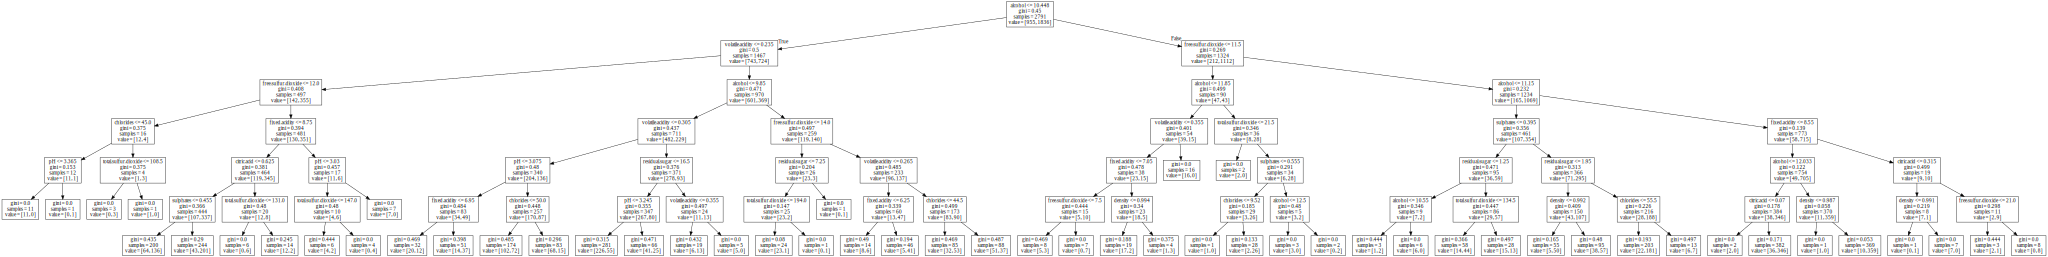

In [10]:
export_graphviz(classification_tree_wine, 
                out_file = "carseat_tree.dot", 
                feature_names = predictor_cols)

with open("carseat_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [11]:
# The snippet below will retrieve the feature importances from the model and make them into a DataFrame.
feature_importances = pd.DataFrame(classification_tree_wine.feature_importances_,
                                   index = predictor_cols,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
alcohol,0.446059
volatile.acidity,0.195163
free.sulfur.dioxide,0.098562
fixed.acidity,0.050128
total.sulfur.dioxide,0.035917
chlorides,0.035191
pH,0.033721
residual.sugar,0.027868
density,0.026915
citric.acid,0.026106


In [12]:
yPred = classification_tree_wine.predict(xTest)
print("Confusion Matrix:")
print(confusion_matrix(yTest, yPred))

print("Classification Report:")
print(classification_report(yTest, yPred))

Confusion Matrix:
[[154  96]
 [ 87 361]]
Classification Report:
               precision    recall  f1-score   support

Disappointing       0.64      0.62      0.63       250
         Good       0.79      0.81      0.80       448

     accuracy                           0.74       698
    macro avg       0.71      0.71      0.71       698
 weighted avg       0.74      0.74      0.74       698



### Or you can consider different models using cross validation

In [13]:
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Average score: 0.766401541349669')

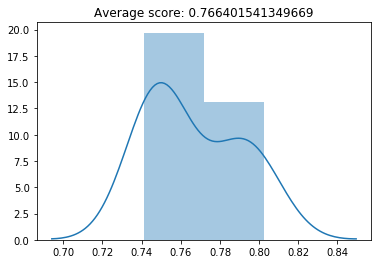

In [14]:

dtc = DecisionTreeClassifier()
cv_scores = cross_val_score(dtc, train_X_imp, train_y, cv=10)
sns.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

### Parameter Tuning

In every classification technique, there are some parameters that can be tuned to optimize the classification. Some parameters that can be tuned in the decision tree is max depth (the depth of the tree), max feature (the feature used to classify), criterion, and splitter.

To search to tune parameter is to use Grid Search. Basically, it explores a range of parameters and finds the best combination of parameters. Then repeat the process several times until the best parameters are discovered. We will also use Stratified k-fold cross-validation that will prevent a certain class only split them to the same subset.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [33]:
dtc = DecisionTreeClassifier()
parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3],
                  'max_features': [1, 2, 3]}

cross_validation = StratifiedKFold(n_splits=10)
cross_validation.get_n_splits(train_X_imp, train_y)
#Create the scoring dictionary
SCORING = {'accuracy': 'accuracy',
'balanced_accuracy': 'balanced_accuracy',
'precision': 'precision_macro',
'recall': 'recall_macro',
'f1': 'f1_macro'}

grid_search = GridSearchCV(dtc, param_grid=parameter_grid, cv=cross_validation, )
#grid_search = GridSearchCV(dtc, param_grid=parameter_grid, cv=cross_validation, scoring=SCORING,return_train_score=True, refit='accuracy')

grid_search.fit(train_X_imp, train_y)


/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classifica

/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classifica

/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classifica

/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classifica

/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classifica

/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classifica

/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classifica

/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classifica

/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iserina/.local/lib/python3.6/site-packages/sklearn/metrics/_classifica

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              pres...
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3], 'max_features': [1, 2, 3],
            

In [31]:
grid_search.cv_results_

{'mean_fit_time': array([0.00602837, 0.00578613, 0.00558567, 0.0050909 , 0.00665503,
        0.00578804, 0.00556793, 0.00556645, 0.0065455 , 0.00520108,
        0.00684047, 0.00529003, 0.00617301, 0.00555215, 0.00717752,
        0.00633786, 0.00809119, 0.006006  , 0.00601561, 0.00546291,
        0.0066484 , 0.00529099, 0.00718102, 0.00568652, 0.00607076,
        0.00509698, 0.00661075, 0.00533013, 0.00721149, 0.00537059,
        0.00631719, 0.00544577, 0.0074847 , 0.00631762, 0.00923052,
        0.00572326]),
 'std_fit_time': array([0.00058501, 0.00123992, 0.00026424, 0.00011781, 0.00062871,
        0.00126826, 0.00012854, 0.00067116, 0.00061115, 0.000299  ,
        0.0003656 , 0.00015038, 0.00042174, 0.00039782, 0.00047433,
        0.00117896, 0.00073157, 0.00048092, 0.00054061, 0.00064288,
        0.00085492, 0.00021039, 0.00161225, 0.0005947 , 0.00031779,
        0.00014482, 0.00051696, 0.00038785, 0.00053539, 0.00022477,
        0.00036572, 0.0006299 , 0.00036085, 0.00186891, 0.001

In [30]:
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

best_dtc = grid_search.best_estimator_
best_dtc

Best score: 0.6953265487600039
Best parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'splitter': 'best'}


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [17]:
my_model=best_dtc
my_model.fit(train_X_imp, train_y)
my_model.score(train_X_imp, train_y)

0.7664087130983089

### Build the final model

In [18]:
y_pred = my_model.predict(train_X_imp)
print("Confusion Matrix:")
print(confusion_matrix(train_y, y_pred))

print("Classification Report:")
print(classification_report(train_y, y_pred))

Confusion Matrix:
[[ 706  499]
 [ 316 1968]]
Classification Report:
               precision    recall  f1-score   support

Disappointing       0.69      0.59      0.63      1205
         Good       0.80      0.86      0.83      2284

     accuracy                           0.77      3489
    macro avg       0.74      0.72      0.73      3489
 weighted avg       0.76      0.77      0.76      3489



In [19]:
# The snippet below will retrieve the feature importances from the model and make them into a DataFrame.
feature_importances = pd.DataFrame(my_model.feature_importances_,
                                   index = train_X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
volatile.acidity,0.226152
total.sulfur.dioxide,0.183534
alcohol,0.168428
density,0.164887
free.sulfur.dioxide,0.122290
sulphates,0.039656
chlorides,0.038276
residual.sugar,0.031434
pH,0.013498
citric.acid,0.011844


In addition to your training data, there will be test data. This is frequently stored in a file with the title `test.csv`. This data won't include a column with your target (y), because that is what we'll have to predict and submit.  Here is sample code to do that. 

In [20]:
# Read the test data
test = pd.read_csv('https://raw.githubusercontent.com/serivan/mldmlab/master/Datasets/Kaggle2020/test.csv')


# Treat the test data in the same way as training data. In this case, pull same columns.
test_X = test[predictor_cols]

# Impute each test item, then predict
test_X_imp = imp.transform(test_X)

# Use the model to make predictions
predicted_q = my_model.predict(test_X_imp)
# We will look at the predicted Qualities to ensure we have something sensible.
print(predicted_q)


['Disappointing' 'Good' 'Good' ... 'Good' 'Good' 'Good']


# Prepare Submission File
We make submissions in CSV files.  Your submissions usually have two columns: an ID column and a prediction column.  The ID field comes from the test data (keeping whatever name the ID field had in that data, which for the housing data is the string 'Id'). The prediction column will use the name of the target field.

We will create a DataFrame with this data, and then use the dataframe's `to_csv` method to write our submission file.  Explicitly include the argument `index=False` to prevent pandas from adding another column in our csv file.

In [21]:
my_submission = pd.DataFrame({'Id': test.Id, 'Quality': predicted_q})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)

# Make Submission
Hit the blue **Publish** button at the top of your notebook screen.  It will take some time for your kernel to run.  When it has finished your navigation bar at the top of the screen will have a tab for **Output**.  This only shows up if you have written an output file (like we did in the **Prepare Submission File** step).  

Otherwise, if you have a kaggle API token, you can use the following command (remove the '#'):

In [22]:
# !kaggle competitions submit -c mldm-classification-competition-2020 -f submission.csv -m "Please describe the technique used"


# Last Steps 
Click on the Output button.  This will bring you to a screen with an option to **Submit to Competition**.  Hit that and you will see how your model performed.

If you want to go back to improve your model, click the Edit button, which re-opens the kernel.  You'll need to re-run all the cells when you re-open the kernel.

# Conclusion
You've completed Level 1 of Machine Learning.  Congrats.  

If you are ready to keep improving your model (and your skills), start level 2 of [Learn Machine Learning](https://www.kaggle.com/learn/machine-learning). 

Level 2 covers more powerful models, techniques to include non-numeric data, and more.  You can make more submissions to the competition and climb up the leaderboard as you go through the course.


